In [23]:
%matplotlib inline
import sys
sys.path.append("/home/oneunreadmail/PycharmProjects/ragequit/")
from importlib import reload
import math
import itertools
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import model_selection, ensemble
from sklearn.metrics import accuracy_score, log_loss
import xgboost as xgb

import tflow 
reload(tflow)

<module 'tflow' from '/home/oneunreadmail/PycharmProjects/ragequit/tflow.py'>

In [24]:
class FitError(Exception):
    pass

In [25]:
# функция на работу с уже полученными вероятностями
# пока не в деле, но я думаю, что их хитрым образом можно как-то потрогать и улучшить логлосс
def expand(array, func=""):
    if func == "drop":
        f = lambda x: x + math.tan((-x + 0.5)*2.7)/10000
    elif func == "tocenter":
        f = lambda x: x - math.sin((x - 0.5)*2*math.pi)/10000
    else:
        f = lambda x: x
    return list(map(f, array))

#a = np.arange(0, 1, 0.01)
#expand(a, func="tocenter")

In [26]:
# делает из листа листов листов листов один плоский лист
def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        if hasattr(s,'__iter__'):
            flatten(s,container)
        else:
            container.append(s)
    return container

# считает элементы в листе листов листов листов
# тупо чтобы проверить, что мы не потеряли строчки где-то
def flat_len(seq):
    return len(flatten(seq))

In [27]:
# выдает лист из всех комбинаций элементов входого листа
# all_perm(["0", "1", "2"])
# (['2', '1', '0'], ['1', '0'], ['2', '0'], ['0'], ['2', '1'], ['1'], ['2'], [])
def all_perm(list):
    if len(list) == 1:
        return [list[0]],[]
    else:
        ap = all_perm(list[1:])
        #print(ap)
        #print(tuple(lst + [list[0]] for lst in ap))
        #print(tuple(lst for lst in ap))
        return (tuple(lst + [list[0]] for lst in ap)) + (tuple(lst for lst in ap))

#all_perm(["0", "1", "2"])

In [28]:
# сплиттит датафреймы по листу из n индексов
# выдает тупл из 2**n элементов, каждый - лист из номеров строк
def df_split(df, indices = []):
    if len(indices) > 1:
        left =  df_split(df[df[indices[0]] == 0], indices[1:])
        right = df_split(df[df[indices[0]] == 1], indices[1:])
        assert(len(df.index) == flat_len(left) + flat_len(right))
        return left + right
    elif len(indices) == 1:
        left = list(df[df[indices[0]] == 0].index)
        right = list(df[df[indices[0]] == 1].index)
        #if not left: return right,
        #elif not right: return left,
        #else: 
        return left, right
    else:
        return list(df.index),

#f = x_train[["maxPlayerLevel", "attLevelsMoreThanMaxLevel", "doReturnOnLowerLevels", "allAttemptsOnTheHighestLevel"]][30:50]
#f = x_train[["maxPlayerLevel", "true"]][30:35]
#f.loc[30:35]
#g = df_split(f)
#g = df_split(f, [])
#g = df_split(f, ["attLevelsMoreThanMaxLevel"])
#g = df_split(f, ["attLevelsMoreThanMaxLevel", "doReturnOnLowerLevels", "allAttemptsOnTheHighestLevel"])
#for i in g: print(i)
#f.loc[g[1]]

#df_split(f, ["attLevelsMoreThanMaxLevel", "doReturnOnLowerLevels", "allAttemptsOnTheHighestLevel"])

In [29]:
# класс с нашими моделями
# сразу при вызове забирает данные из глобальных x_test, t_train и y_train
# учитывает только колонки из листа params (локальный, обязательный)
# бьет их на части из листа split (локальный, необязательный)
# сразу все фитует и даже считает y_test

class ML():
    model = None
    errors = None
    log_loss = None
    data = []
    test_out = None
    
    
    def __init__(self, model, params, split=[]):
        self.params = params
        self.model = model
        self.split = split
        self.form()
        self.fit()

    
    def form(self):
        self.train_indices = df_split(x_train, self.split)
        self.test_indices = df_split(x_test, self.split)
        
        # проверяем по всем кускам
        # если куска нет в трейне, то обучить тест не получится
        for i in self.train_indices:
            if (i == []) and (self.test_indices != []):
                raise FitError('CANT FIT DIS: some empty train stuff but not test one, u know')
        
    
    def fit(self):
        y1v, y2v, y1p, y2p, y1r, y2r = [], [], [], [], [], []
        out, xtr = [], []
        for i, index in enumerate(self.train_indices):
            if len(index) == 0: continue
            x_train_part = x_train[self.params].loc[index]
            y_train_part = list(y_train.returned.loc[index])
            x1, x2, y1, y2 = train_test_split(x_train_part, y_train_part, test_size = 0.3, random_state=42)
            
            try:
                self.model.fit(x1, y1, eval_metric=’logloss’)
            except ValueError:
                raise FitError("CANT FIR DIS: looks like it needs more rows or something else")
            
            # values
            y1v.append(self.model.predict(x1))
            y2v.append(self.model.predict(x2))
            # probabilities
            y1p.append(self.model.predict_proba(x1))
            y2p.append(self.model.predict_proba(x2))
            # true values
            y1r.append(np.array(y1))
            y2r.append(np.array(y2))
            # applying model to test values
            if len(self.test_indices[i]) != 0:
                # если есть кусок теста, отфитуем его
                x_test_part = x_test[self.params].loc[self.test_indices[i]]
                out.append(self.model.predict_proba(x_test_part)[:, 1])
        
        # будем все собирать
        # следующие шесть можно собирать не по порядку, какая в жопу разница, логлоссу все равно
        y1v = np.concatenate(y1v)
        y2v = np.concatenate(y2v)
        y1p = np.concatenate(y1p)
        y2p = np.concatenate(y2p)
        y1r = np.concatenate(y1r)
        y2r = np.concatenate(y2r)

        # а вот для ответов на тесты следим за рукой
        # пока что out это лист из массивов с предсказаниями для разных кусков
        # теперь сделаем из него лист из двумерных массивов вида "номера корректных строк", "предсказания"
        out1 = [np.array([self.test_indices[_], __]) for _, __ in enumerate(out)]
        # соберем один двумерный массив из этой кучи
        # теперь там куча строк вида [1, 0.44] [2, 0.62], но номера перепутаны, потому что мы резали
        out2 = np.concatenate(out1, axis=1).transpose()
        # отсортируем
        out3 = out2[np.argsort(out2[:, 0])]
        # запишем предсказания для теста и вот мы молодцы
        self.test_out = out3[:, 1]
        
        self.errors = np.mean(y1r != y1v), np.mean(y2r != y2v)
        self.log_loss = log_loss(y1r, y1p, eps=1e-15), log_loss(y2r, y2p, eps=1e-15)
                              
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]
        #print(len(indices), len(self.params), len(importances))
        self.imp = [(self.params[i], importances[i]) for i in indices]
    
    def dump(self):
        #a = self.model.predict_proba(data)
        np.savetxt("data/y_test.csv", self.test_out, fmt='%10.5f')

#XGB = ML(xgb.XGBClassifier(), params, split=params_split)

SyntaxError: invalid character in identifier (<ipython-input-29-af0afc5781ea>, line 44)

In [30]:
xytte = pd.read_csv("data/xytte.csv")
xytte["true"] = 1
xytt2e = xytte.copy()
#for i in range(len(xytte.index)):
#    for j in range(i+1, len(xytte.index)):
#        #print(xytte.iloc[:, [i]])
#        xytt2e[str(i)+"_"+str(j)] = xytte.iloc[:, [i]] * xytte.iloc[:, [j]]

print(xytt2e)
####################### ВНИМАНИЕ #######################
# здесь трейн это которые в задаче трейн, с ответами
# тест без ответов
# но дальше в алгоритмах трейн будет разбиваться на два подсета
# которые будут у меня называться x1-y1 и x2-y2, а по смыслу как раз трейн и тест
# надо не перепутать

x_train = xytte[xytte.returned == xytte.returned].reset_index(drop=True).drop("returned", axis=1)
y_train = xytte[xytte.returned == xytte.returned].reset_index(drop=True)[["returned"]]
x_test  = xytte[xytte.returned != xytte.returned].reset_index(drop=True).drop("returned", axis=1)

FileNotFoundError: File b'data/xytte.csv' does not exist

In [9]:
# проверяем, что нигде не налажали
# читаем из файла оригинальные данные

x_test_ref = pd.read_csv("data/x_test.csv", sep=";", dtype=np.float32)
x_train_ref = pd.read_csv("data/x_train.csv", sep=";", dtype=np.float32)
y_train_ref = pd.read_csv("data/y_train.csv", sep=";", dtype=np.float32, header=None, names=["returned"])

# заводим функцию на сравнение таблиц

def df_equal(df1, df2):
    if list(df1.columns) != list(df2.columns): 
        print("Mismatch columns:")
        print("df1: ", list(df1.columns))
        print("df2: ", list(df2.columns))
        return False
    if list(df1.index) != list(df2.index): 
        print("Mismatch index:")
        print("df1: ", list(df1.columns)[0], ":", list(df1.columns)[-1])
        print("df2: ", list(df2.columns)[0], ":", list(df2.columns)[-1])
        return False
    
    ne_stacked = (df1 != df2).stack()
    changed = ne_stacked[ne_stacked]
    changed.index.names = ['id', 'col']

    difference_locations = np.where(df1 != df2)
    changed_from = df1.values[difference_locations]
    changed_to = df2.values[difference_locations]
    diff = pd.DataFrame({'from': changed_from, 'to': changed_to}, index=changed.index)
    return not diff[diff["from"] - diff["to"] > 0.000001].count()[0]

# ассертим наши таблицы

assert(df_equal(x_test[x_test_ref.columns], x_test_ref))
assert(df_equal(x_train[x_train_ref.columns], x_train_ref))
assert(df_equal(y_train, y_train_ref))

In [10]:
params_all = list(x_train.columns)

params_orig = [
'maxPlayerLevel',
'numberOfAttemptedLevels',
'attemptsOnTheHighestLevel',
'totalNumOfAttempts',
'averageNumOfTurnsPerCompletedLevel',
'numberOfBoostersUsed',
'fractionOfUsefullBoosters',
'totalScore',
'totalBonusScore',
'totalStarsCount',
'numberOfDaysActuallyPlayed',
]
     
params_mod = [
#'attemptsOnTheHighestLevel_dvd',
'attemptsOnTheHighestLevel_ln',
'attemptsPerDay',
'averageNumOfTurnsPerCompletedLevel_dvd',
'maxPlayerLevel_ln',
'numberOfAttemptedLevels_dvd',
#'numberOfBoostersUsed_dvd',
'numberOfBoostersUsed_dvd_ln',
#'numberOfBoostersUsed_ln',
'numberOfDaysActuallyPlayed_ln',
'totalBonusScore_dvd',
'totalNumOfAttempts_ln',
#'totalScore_ln',
'totalScore_ln_dvd',
#'totalStarsCount_dvd',
'totalStarsCount_dvd_ln',
#'totalStarsCount_ln',
]

params_bool = [
'allAttemptsOnTheHighestLevel',
'attLevelsMoreThanMaxLevel',
'doReturnOnLowerLevels',
'zeroTotalScore',
'zeroTurnsPerCompletedLevel'
]

params_orig_norm = [
'attemptsOnTheHighestLevel_norm',
'attemptsPerDay_norm',
#'numberOfBoostersUsed_norm',
#'maxPlayerLevel_norm',
'fractionOfUsefullBoosters_norm',
#'averageNumOfTurnsPerCompletedLevel_norm',
'numberOfDaysActuallyPlayed_norm',
'totalNumOfAttempts_norm',
'totalBonusScore_norm',
'totalScore_norm',
'totalStarsCount_norm',
]

params_mod_norm = [
'attemptsOnTheHighestLevel_dvd_norm',
#'attemptsOnTheHighestLevel_ln_norm',
'averageNumOfTurnsPerCompletedLevel_dvd_norm',
'maxPlayerLevel_ln_norm',
'numberOfAttemptedLevels_dvd_norm',
#'numberOfAttemptedLevels_norm',
'numberOfBoostersUsed_dvd_ln_norm',
#'numberOfBoostersUsed_dvd_norm',
#'numberOfBoostersUsed_ln_norm',
'numberOfDaysActuallyPlayed_ln_norm',
'totalBonusScore_dvd_norm',
'totalNumOfAttempts_ln_norm',
'totalScore_ln_dvd_norm',
#'totalScore_ln_norm',
'totalStarsCount_dvd_ln_norm',
#'totalStarsCount_dvd_norm',
'totalStarsCount_ln_norm',
]

params_rf_sorted = [
'numberOfDaysActuallyPlayed_ln',
'totalNumOfAttempts',
'totalBonusScore_dvd_norm',
'averageNumOfTurnsPerCompletedLevel',
'totalScore_ln_dvd',
'averageNumOfTurnsPerCompletedLevel_dvd',
'maxPlayerLevel_ln_norm',
'attemptsOnTheHighestLevel_dvd_norm',
'totalStarsCount_dvd_norm',
'attemptsPerDay_norm',
'numberOfBoostersUsed_dvd_norm',
'fractionOfUsefullBoosters_norm',
'numberOfAttemptedLevels_dvd_norm',
'doReturnOnLowerLevels',
'attLevelsMoreThanMaxLevel',
'allAttemptsOnTheHighestLevel',
'zeroTotalScore',
'zeroTurnsPerCompletedLevel'
]

params_gb_sorted = [
'averageNumOfTurnsPerCompletedLevel_norm',
'numberOfDaysActuallyPlayed_norm',
'attemptsPerDay_norm',
'totalNumOfAttempts',
'numberOfDaysActuallyPlayed',
'attemptsOnTheHighestLevel_dvd',
'numberOfBoostersUsed_dvd',
'totalScore_ln_dvd',
'fractionOfUsefullBoosters',
'maxPlayerLevel_norm',
'numberOfAttemptedLevels_dvd',
'totalBonusScore_norm',
'totalStarsCount_dvd_norm'
]

In [11]:
#params = params_orig + ["doReturnOnLowerLevels"]
#params = params_mod_norm + params_bool
#params = params_bool
#params = params_bool + params_orig
#params = params_all
params = params_rf_sorted
#paramslist(y_train)

In [12]:
"""
x_train_feed = x_train[params]
x_test_feed = x_test[params]
y_train_feed = list(y_train.returned)
#y_test_feed = list(y_test)

x1, x2, y1, y2 = train_test_split(x_train_feed, y_train_feed, test_size = 0.3, random_state=42)

assert(set(list(x_train_feed.columns)) == set(list(x_test_feed.columns)))
assert(set(list(x1.columns)) == set(list(x2.columns)))
assert(type(y1) == list)
assert(type(y2) == list)
assert(len(y1) == len(x1.index))
assert(len(y2) == len(x2.index))

#list(x1.columns), list(x2.columns) 
"""

'\nx_train_feed = x_train[params]\nx_test_feed = x_test[params]\ny_train_feed = list(y_train.returned)\n#y_test_feed = list(y_test)\n\nx1, x2, y1, y2 = train_test_split(x_train_feed, y_train_feed, test_size = 0.3, random_state=42)\n\nassert(set(list(x_train_feed.columns)) == set(list(x_test_feed.columns)))\nassert(set(list(x1.columns)) == set(list(x2.columns)))\nassert(type(y1) == list)\nassert(type(y2) == list)\nassert(len(y1) == len(x1.index))\nassert(len(y2) == len(x2.index))\n\n#list(x1.columns), list(x2.columns) \n'

In [13]:
RF = ML(ensemble.RandomForestClassifier(n_estimators=200, max_features=10, random_state=42),
        params_rf_sorted)

In [14]:
print(RF.log_loss)

(0.11315754714695353, 0.46972305554348548)


In [15]:
GB = ML(ensemble.GradientBoostingClassifier(n_estimators=100, random_state=42), 
        params_gb_sorted)

In [16]:
print(GB.log_loss)
#pprint(GB.imp)
#for i in GB.imp: print(i[0])

(0.36954064074598247, 0.37820870447373117)


In [25]:
XGB = ML(xgb.XGBClassifier(),
        params_gb_sorted,
        split=["zeroTotalScore"])

In [26]:
print(XGB.log_loss)

(0.36714156339229764, 0.37983107549635881)


In [32]:
import tflow
TF = ML(tflow.nnetwork(),
        params_gb_sorted)

NameError: name 'nn_layer' is not defined

In [ ]:
# как перебирать по набору параметров

results = []
for i, params in enumerate([params_orig, 
                            params_mod, 
                            params_bool, 
                            params_orig_norm, 
                            params_mod_norm, 
                            params_rf_sorted, 
                            params_all,
                            params_gb_sorted,
                           ]):
    try:
        XGB = ML(xgb.XGBClassifier(max_depth=6), params)
        results.append((XGB.log_loss[1], i))
    except FitError:
        pass
results.sort()
pprint(results[:5])

In [ ]:
# как перебирать по сплитам

params_split = [
'allAttemptsOnTheHighestLevel',
'attLevelsMoreThanMaxLevel',
'doReturnOnLowerLevels',
'zeroTotalScore',
'zeroTurnsPerCompletedLevel'
]

params_split_combs = all_perm(params_split)
results = []
for split in params_split_combs:
    try:
        XGB = ML(xgb.XGBClassifier(max_depth=6), params_mod, split=split)
        results.append((XGB.log_loss[1], split))
    except FitError:
        pass
results.sort()
pprint(results[:5])

In [ ]:
# как перебирать по параметрам

depths = [4, 5, 6]
learning_rates = [0.08, 0.1, 0.12]
estimators = [55, 70, 85, 100]
results = []
for depth, learning_rate, n_estimators in itertools.product(depths, learning_rates, estimators):
    try:
        XGB = ML(xgb.XGBClassifier(max_depth=depth, 
                                   learning_rate=learning_rate, 
                                   n_estimators=n_estimators), params_mod, split=[])
        results.append((XGB.log_loss[1], XGB.log_loss[0], depth, learning_rate, n_estimators))
    except FitError:
        pass
results.sort()
pprint(results[:5])
#max_depth=3, learning_rate=0.1, n_estimators=100

In [1]:
XGB = ML(xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=70), params_mod + params_bool, split=[])
#print(XGB.log_loss)
#XGB.dump()

NameError: name 'ML' is not defined

In [900]:
from sklearn import svm, grid_search, datasets
parameters = {'max_depth':(2, 3, 4), 'learning_rate':[0.105, 0.11, 0.115]}
svr = xgb.XGBClassifier()
clf = grid_search.GridSearchCV(XGB.model, parameters)
clf.fit(x_train[params_mod], list(y_train.returned))
clf.best_params_

{'learning_rate': 0.11, 'max_depth': 3}

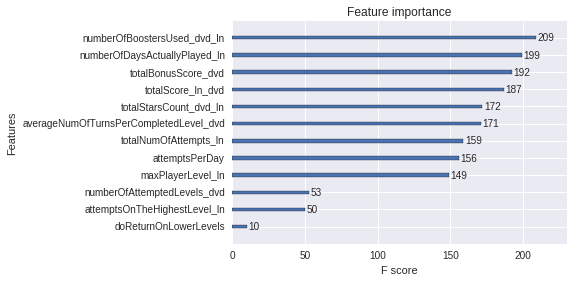

In [908]:
xgb.plot_importance(XGB.model)